In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from scipy.stats import randint
import numpy as np
import joblib

In [2]:
def extract_poker_features(df):
    df = df.copy()

    values = df[['C1','C2','C3','C4','C5']]
    suits  = df[['S1','S2','S3','S4','S5']]

    df['max_value'] = values.max(axis=1)
    df['min_value'] = values.min(axis=1)
    df['range_value'] = df['max_value'] - df['min_value']

    df['n_unique_values'] = values.nunique(axis=1)
    df['n_unique_suits'] = suits.nunique(axis=1)

    counts = values.apply(lambda row: row.value_counts().to_dict(), axis=1)

    df['has_pair']       = counts.apply(lambda c: 2 in c.values())
    df['has_two_pair']   = counts.apply(lambda c: list(c.values()).count(2) == 2)
    df['has_three_kind'] = counts.apply(lambda c: 3 in c.values())
    df['has_four_kind']  = counts.apply(lambda c: 4 in c.values())
    df['has_full_house'] = counts.apply(lambda c: (3 in c.values()) and (2 in c.values()))

    df['is_flush'] = df['n_unique_suits'] == 1

    def is_straight(vals):
        vals = sorted(vals)
        return vals == list(range(vals[0], vals[0] + 5))

    df['is_straight'] = values.apply(lambda row: is_straight(row.values.tolist()), axis=1)

    df['is_straight_flush'] = df['is_straight'] & df['is_flush']

    df['mean_value'] = values.mean(axis=1)
    df['std_value']  = values.std(axis=1)

    def value_gaps(vals):
        vals = sorted(vals)
        return np.mean([vals[i+1]-vals[i] for i in range(4)])

    df['mean_gap'] = values.apply(lambda row: value_gaps(row.values.tolist()), axis=1)

    df['median_value'] = values.median(axis=1)

    return df


In [3]:
def group_hand(h):
    if h in [0, 1]:
        return 0
    if h in [2, 3, 4, 5]:
        return 1
    return 2

In [4]:
cols = ['S1','C1','S2','C2','S3','C3','S4','C4','S5','C5','hand']

train = pd.read_csv("poker-hand-training-true.data", header=None)
test  = pd.read_csv("poker-hand-testing.data", header=None)

train.columns = cols
test.columns  = cols

train["hand_group"] = train["hand"].apply(group_hand)
test["hand_group"]  = test["hand"].apply(group_hand)

train_fe = extract_poker_features(train)
test_fe  = extract_poker_features(test)

X_train = train_fe.drop(["hand", "hand_group"], axis=1)
y_train = train_fe["hand_group"]

X_test  = test_fe.drop(["hand", "hand_group"], axis=1)
y_test  = test_fe["hand_group"]


In [10]:
distribucion = train['hand_group'].value_counts(normalize=True).sort_index() * 100
distribucion

hand_group
0    92.331068
1     7.461016
2     0.207917
Name: proportion, dtype: float64

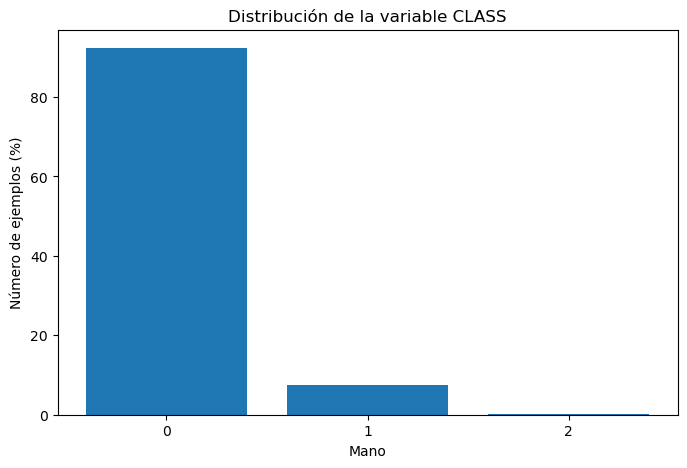

In [8]:
plt.figure(figsize=(8,5))
plt.bar(distribucion.index.astype(str), distribucion.values)
plt.xlabel("Mano")
plt.ylabel("Número de ejemplos (%)")
plt.title("Distribución de la variable CLASS")
plt.show()

In [ ]:
smote = SMOTE(random_state=42, k_neighbors=3)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


c:\Users\andre\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] El sistema no puede encontrar el archivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\andre\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\andre\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\andre\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^

In [11]:
y_train.value_counts(), y_train_res.value_counts()

(hand_group
 0    23092
 1     1866
 2       52
 Name: count, dtype: int64,
 hand_group
 2    23092
 0    23092
 1    23092
 Name: count, dtype: int64)

In [ ]:
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled      = scaler.transform(X_test)

X_train_res_scaled = pd.DataFrame(X_train_res_scaled, columns=X_train.columns)
X_test_scaled      = pd.DataFrame(X_test_scaled, columns=X_train.columns)


In [ ]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_res_scaled, y_train_res)

y_pred_knn = knn.predict(X_test_scaled)
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

KNN Accuracy: 0.998205
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    923707
           1       0.99      0.99      0.99     74624
           2       0.95      0.87      0.91      1669

    accuracy                           1.00   1000000
   macro avg       0.98      0.95      0.97   1000000
weighted avg       1.00      1.00      1.00   1000000



In [ ]:
y_pred_knn

In [14]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=6, random_state=42)
dt.fit(X_train_res_scaled, y_train_res)

y_pred_dt = dt.predict(X_test_scaled)
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))


Decision Tree Accuracy: 0.998828
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    923707
           1       1.00      0.98      0.99     74624
           2       0.68      1.00      0.81      1669

    accuracy                           1.00   1000000
   macro avg       0.89      0.99      0.93   1000000
weighted avg       1.00      1.00      1.00   1000000

